# 0: Import Statements

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os

import matplotlib
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors
import math, bisect
import matplotlib.colors as mcolors

from pandas.plotting import parallel_coordinates
from pandas.api.types import CategoricalDtype
from itertools import product

import warnings
warnings.filterwarnings("ignore")

# spatial analysis
import geopandas as gpd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [1]:
# This fpath should be modified to your directory address
fpath = '/cluster/tufts/lamontagnelab/gkim14/P2_Hydro_Climate/Zenodo_Organization/Data/'

In [14]:
# Read Basin Mapping Keys
basinid_gluname = pd.read_csv(fpath+'mapping/basin_to_country_mapping.csv')
gluname_region = pd.read_csv(fpath+'mapping/basin_to_region_mapping.csv')

# load in map of global GCAM basins & Regions
gcam_regions = gpd.read_file(fpath+'mapping/gcam_regions/gcam_regions.shp')
gcam_regions = gcam_regions.filter(['sbRgnAl','geometry','area','subRegn'])
gcam_regions = gcam_regions.rename(columns={'sbRgnAl':'Region_ID','subRegn':'region'})

gcam_regions1 = gcam_regions.assign(region = lambda x: x.region.str.replace('EU_12','EU-12',regex=True))
gcam_regions2 = gcam_regions1.assign(region = lambda x: x.region.str.replace('EU_15','EU-15',regex=True))
gcam_regions2['Region_ID'] = gcam_regions['Region_ID'].astype(int)

gcam_basin_region = gpd.read_file(fpath+'mapping/gcam_map_main_outputs/reg_glu_boundaries_moirai_combined_3p1_0p5arcmin.shp')
gcam_basin_region = gcam_basin_region.rename(columns={'glu_id':'basin_id'})
gcam_basin_region['basin_id'] = gcam_basin_region['basin_id'].astype(int)
gcam_basin_region['reg_id'] = gcam_basin_region['reg_id'].astype(int)

In [15]:
gcam_basin_region['glu_nm'] = gcam_basin_region.glu_nm.str.replace(')','')
gcam_basin_region['glu_nm'] = gcam_basin_region.glu_nm.str.replace('(','')

gcam_basin_region['glu_nm'] = gcam_basin_region.glu_nm.str.replace('Yenisey','Yenisei')
gcam_basin_region['glu_nm'] = gcam_basin_region.glu_nm.str.replace('Rhne','Rhone')
gcam_basin_region['glu_nm'] = gcam_basin_region.glu_nm.str.replace('Brahamani','Brahmani')
gcam_basin_region['glu_nm'] = gcam_basin_region.glu_nm.str.replace('Mahandi','Mahanadi')
gcam_basin_region['glu_nm'] = gcam_basin_region.glu_nm.str.replace('Rfo_Balsas','Rio_Balsas')
gcam_basin_region['glu_nm'] = gcam_basin_region.glu_nm.str.replace('Rfo_Lerma','Rio_Lerma')
gcam_basin_region['glu_nm'] = gcam_basin_region.glu_nm.str.replace('Rfo_Verde','Rio_Verde')
gcam_basin_region['glu_nm'] = gcam_basin_region.glu_nm.str.replace('Sittang','Sittaung')

gcam_basin_region['reg_bsn'] = gcam_basin_region['reg_nm'] + '_' + gcam_basin_region['glu_nm']

In [16]:
#load in mapping CSVs - this is so we are assigning the correct region

basinid_gluname = pd.read_csv(fpath + 'mapping/basin_to_country_mapping.csv')
gluname_region = pd.read_csv(fpath + 'mapping/basin_to_region_mapping_v53.csv')
gluname_region_v53 = pd.read_csv(fpath + 'mapping/basin_to_region_mapping_v53.csv')

#make dictionaries
bsnname_dict = dict(zip(basinid_gluname.GCAM_basin_ID, basinid_gluname.GLU_name))
bsnreg_dict = dict(zip(gluname_region.gcam_basin_name, gluname_region.region))
bsnreg_dict_v53 = dict(zip(gluname_region_v53.gcam_basin_name, gluname_region_v53.Rmap_v53))

In [17]:
fut_years = [2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100]
fut_years_2050 = [2020,2025,2030,2035,2040,2045,2050]

GJ_to_MWh = 0.27777777778
EJ_to_Twh = 277.7778
Twh_to_EJ = 1/EJ_to_Twh

USD1975_to_USD2020 = 4.8106

# 1: Import Processed GCAM Outputs + Modify

In [19]:
elec_gen_tech = pd.read_csv(fpath + 'Processed_Data/elec_gen_tech_final_ensemble.csv')

co2_energy_ref =  pd.read_csv(fpath + 'Processed_Data/co2_tech_final_ensemble_ref.csv')
co2_energy_net =  pd.read_csv(fpath + 'Processed_Data/co2_tech_final_ensemble_net.csv')
co2_beccs_ref =  pd.read_csv(fpath + 'Processed_Data/co2_no_bio_final_ensemble_ref.csv')
co2_beccs_net =  pd.read_csv(fpath + 'Processed_Data/co2_no_bio_final_ensemble_net.csv')
co2_luc_ref =  pd.read_csv(fpath + 'Processed_Data/luc_emissions_merge_final_ensemble_ref.csv')
co2_luc_net =  pd.read_csv(fpath + 'Processed_Data/luc_emissions_merge_final_ensemble_net.csv')

co2_sector_mapping = pd.read_csv(fpath + 'mapping/CO2_sector_mapping.csv')

In [32]:
co2_energy = pd.concat([co2_energy_ref, co2_energy_net])
co2_beccs = pd.concat([co2_beccs_ref, co2_beccs_net])
co2_luc = pd.concat([co2_luc_ref, co2_luc_net])

In [20]:
elec_gen_tech_hydro = elec_gen_tech[elec_gen_tech['subsector']=="hydropower"]

In [21]:
elec_gen_tech_hydro_Taiwan = elec_gen_tech[(elec_gen_tech['region']=="Taiwan")&(elec_gen_tech['technology']=="hydro")]
elec_gen_tech_hydro_Taiwan['subsector'] = "hydropower"
elec_gen_tech_hydro_Taiwan['technology'] = "hydro_Taiwan"

elec_gen_tech_hydro_merge = pd.concat([elec_gen_tech_hydro, elec_gen_tech_hydro_Taiwan])
elec_gen_tech_hydro_merge = elec_gen_tech_hydro_merge.assign(reg_bsn = lambda x: x.technology.str.replace('hydro_',''))

elec_gen_tech_total_glb = elec_gen_tech.groupby(['Units','scenario','year'])['value'].sum().reset_index()
elec_gen_tech_hydro_glb = elec_gen_tech_hydro_merge.groupby(['Units','scenario','year'])['value'].sum().reset_index()

elec_gen_tech_total_glb = elec_gen_tech_total_glb.rename(columns={'value':'total_elec'})
elec_gen_tech_hydro_glb = elec_gen_tech_hydro_glb.rename(columns={'value':'total_hydro'})

In [24]:
elec_gen_tech_merge = pd.merge(elec_gen_tech_total_glb, elec_gen_tech_hydro_glb, how = 'left', 
                               on = ['Units','scenario','year'])
elec_gen_tech_merge = elec_gen_tech_merge.assign(hyd_share = lambda x: x.total_hydro / x.total_elec)
elec_gen_tech_merge_fut_yrs = elec_gen_tech_merge[elec_gen_tech_merge.year.isin(fut_years)]

In [25]:
elec_gen_tech_merge_fut_yrs_2100 = elec_gen_tech_merge_fut_yrs[elec_gen_tech_merge_fut_yrs['year']==2100]
elec_gen_tech_merge_fut_yrs_2100_net = elec_gen_tech_merge_fut_yrs_2100[elec_gen_tech_merge_fut_yrs_2100.scenario.str.contains('_net_')]

In [26]:
gcam_glb_hydro_2100 = elec_gen_tech_merge_fut_yrs_2100
gcam_glb_hydro_2100 = gcam_glb_hydro_2100.assign(total_hydro_Twh = lambda x: x.total_hydro * EJ_to_Twh)
gcam_glb_hydro_2100 = gcam_glb_hydro_2100.assign(total_hydro_103Twh = lambda x: x.total_hydro * EJ_to_Twh / 10**3)

gcam_glb_hydro_2100_ref = gcam_glb_hydro_2100[gcam_glb_hydro_2100.scenario.str.contains('_ref_')]

gcam_glb_hydro_2100_vre0 = gcam_glb_hydro_2100[gcam_glb_hydro_2100.scenario.str.contains('_rt0_')]
gcam_glb_hydro_2100_vre1 = gcam_glb_hydro_2100[gcam_glb_hydro_2100.scenario.str.contains('_rt1_')]

gcam_glb_hydro_2100_net = gcam_glb_hydro_2100[gcam_glb_hydro_2100.scenario.str.contains('_net_')]
gcam_glb_hydro_2100_net_vre0 = gcam_glb_hydro_2100_net[gcam_glb_hydro_2100_net.scenario.str.contains('_rt0_')]
gcam_glb_hydro_2100_net_vre1 = gcam_glb_hydro_2100_net[gcam_glb_hydro_2100_net.scenario.str.contains('_rt1_')]

In [27]:
elec_gen_tech_merge = pd.merge(elec_gen_tech_total_glb, elec_gen_tech_hydro_glb, how = 'left', 
                               on = ['Units','scenario','year'])
elec_gen_tech_merge = elec_gen_tech_merge.assign(hyd_share = lambda x: x.total_hydro / x.total_elec)
elec_gen_tech_merge_fut_yrs = elec_gen_tech_merge[elec_gen_tech_merge.year.isin(fut_years)]

# Figure 2: Histograms and Gaussian KDE of Global Hydro Gen in 2100

In [28]:
ipcc_sr15_glb_hydro = pd.read_csv(fpath + 'ipcc_glb_hydro/IPCC_SR15_glb_hydro.csv', index_col = [0])
ipcc_ar6_glb_hydro = pd.read_csv(fpath + 'ipcc_glb_hydro/IPCC_AR6_glb_hydro.csv', index_col = [0])

ipcc_sr15_glb_hydro_2100 = ipcc_sr15_glb_hydro[ipcc_sr15_glb_hydro['year']==2100]
ipcc_ar6_glb_hydro_2100 = ipcc_ar6_glb_hydro[ipcc_ar6_glb_hydro['year']==2100]

ipcc_sr15_glb_hydro_2100 = ipcc_sr15_glb_hydro_2100.assign(value_103 = lambda x: x.value/10**3)
ipcc_ar6_glb_hydro_2100 = ipcc_ar6_glb_hydro_2100.assign(value_103 = lambda x: x.value/10**3)

In [29]:
gcam_glb_hydro_2100 = elec_gen_tech_merge_fut_yrs_2100
gcam_glb_hydro_2100 = gcam_glb_hydro_2100.assign(total_hydro_Twh = lambda x: x.total_hydro * EJ_to_Twh)
gcam_glb_hydro_2100 = gcam_glb_hydro_2100.assign(total_hydro_103Twh = lambda x: x.total_hydro * EJ_to_Twh / 10**3)

gcam_glb_hydro_2100_ref = gcam_glb_hydro_2100[gcam_glb_hydro_2100.scenario.str.contains('_ref_')]

gcam_glb_hydro_2100_vre0 = gcam_glb_hydro_2100[gcam_glb_hydro_2100.scenario.str.contains('_rt0_')]
gcam_glb_hydro_2100_vre1 = gcam_glb_hydro_2100[gcam_glb_hydro_2100.scenario.str.contains('_rt1_')]

gcam_glb_hydro_2100_net = gcam_glb_hydro_2100[gcam_glb_hydro_2100.scenario.str.contains('_net_')]
gcam_glb_hydro_2100_net_vre0 = gcam_glb_hydro_2100_net[gcam_glb_hydro_2100_net.scenario.str.contains('_rt0_')]
gcam_glb_hydro_2100_net_vre1 = gcam_glb_hydro_2100_net[gcam_glb_hydro_2100_net.scenario.str.contains('_rt1_')]

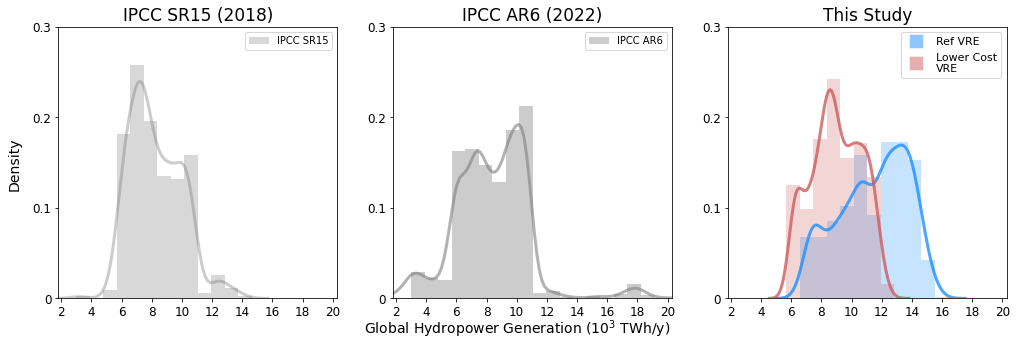

In [31]:
(fig, (ax1,ax2,ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(17,5))   

bins1 = np.linspace(3, 20, 20)
bins2 = np.linspace(3, 20, 20)
bins3 = np.linspace(3, 20, 20)

ax1.hist(ipcc_sr15_glb_hydro_2100.value_103, bins1, alpha=0.3, color="grey", density=True, label='IPCC SR15')
ax2.hist(ipcc_ar6_glb_hydro_2100.value_103, bins2, alpha=0.4, color="grey", density=True, label='IPCC AR6')

ax3.hist(gcam_glb_hydro_2100_vre0.total_hydro_103Twh, bins3, alpha=0.25, color="dodgerblue", density=True)
ax3.hist(gcam_glb_hydro_2100_vre1.total_hydro_103Twh, bins3, alpha=0.25, color="IndianRed", density=True)

sns.kdeplot(ipcc_sr15_glb_hydro_2100.reset_index(drop=True).value_103, 
            color="grey", alpha = 0.4, ax=ax1, lw = 3, label='')
sns.kdeplot(ipcc_ar6_glb_hydro_2100.reset_index(drop=True).value_103, 
            color="grey", alpha = 0.6, ax=ax2, lw = 3, label='')

sns.kdeplot(gcam_glb_hydro_2100_vre0.reset_index(drop=True).total_hydro_103Twh, 
            color="dodgerblue", alpha = 0.8, ax=ax3, lw = 3, label='')
sns.kdeplot(gcam_glb_hydro_2100_vre1.reset_index(drop=True).total_hydro_103Twh,
            color="IndianRed", alpha = 0.8, ax=ax3, lw = 3, label='')

ax1.set_title('IPCC SR15 (2018)', fontsize = 17)
ax2.set_title('IPCC AR6 (2022)', fontsize = 17)
ax3.set_title('This Study', fontsize = 17)

ax1.set_xlim(1.8,20.3); ax2.set_xlim(1.8,20.3); ax3.set_xlim(1.8,20.3)
ax1.set_ylim(0,0.3); ax2.set_ylim(0,0.3); ax3.set_ylim(0,0.3)

ax1.set_xticks([2,4,6,8,10,12,14,16,18,20]); ax1.set_yticks([0,0.1,0.2,0.3])
ax1.set_xticklabels(['2','4','6','8','10','12','14','16','18','20'], fontsize=12)
ax1.set_yticklabels(['0','0.1','0.2','0.3'], fontsize=12)
ax2.set_xticks([2,4,6,8,10,12,14,16,18,20]); ax2.set_yticks([0,0.1,0.2,0.3])
ax2.set_xticklabels(['2','4','6','8','10','12','14','16','18','20'], fontsize=12)
ax2.set_yticklabels(['0','0.1','0.2','0.3'], fontsize=12)
ax3.set_xticks([2,4,6,8,10,12,14,16,18,20]); ax3.set_yticks([0,0.1,0.2,0.3])
ax3.set_xticklabels(['2','4','6','8','10','12','14','16','18','20'], fontsize=12)
ax3.set_yticklabels(['0','0.1','0.2','0.3'], fontsize=12)

fig.text(0.5, 0.04, 'Global Hydropower Generation ($10^3$ TWh/y)', ha='center', va='center', fontsize = 14)
fig.text(0.089, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize = 14)

shape1 = matplotlib.lines.Line2D([], [], color="white", lw=4, marker='s', markerfacecolor="dodgerblue", markersize=14, alpha=.5)
shape2 = matplotlib.lines.Line2D([], [], color="white", lw=4, marker='s', markerfacecolor="IndianRed", markersize=14, alpha=.5)
ax3.legend((shape1, shape2), ('Ref VRE', 'Lower Cost\nVRE'), numpoints=1, loc = 'upper right', prop = { "size": 11 })

# Figure 3: Global Hydro vs other VRE Results in  (w/ CO2 Reduction)

In [34]:
# Net_High Generation Scenario
elec_gen_tech_merge_fut_yrs_2100_net.sort_values(by=['total_hydro'], ascending=False).scenario[25145]

'kim_hydrocc_net_soc5_ec-earth3_r1i1p1f1_ssp585_rt0_bl5_tr5_ccs1'

In [35]:
# Net_Low Generation Scenario
elec_gen_tech_merge_fut_yrs_2100_net.sort_values(by=['total_hydro'], ascending=False).scenario[15355]

'kim_hydrocc_net_soc3_gfdl-esm4_r1i1p1f1_ssp370_rt1_bl1_tr1_ccs5'

In [36]:
net_hi_hydro_sce = "kim_hydrocc_net_soc5_ec-earth3_r1i1p1f1_ssp585_rt0_bl5_tr5_ccs1"
net_lo_hydro_sce = "kim_hydrocc_net_soc3_gfdl-esm4_r1i1p1f1_ssp370_rt1_bl1_tr1_ccs5"

In [37]:
co2_energy_reg = co2_energy.groupby(['scenario','year','region'])['value'].sum().to_frame().reset_index()
co2_beccs_reg = co2_beccs.groupby(['scenario','year','region'])['value'].sum().to_frame().reset_index()
co2_luc_reg = co2_luc.groupby(['scenario','year','region'])['value'].sum().to_frame().reset_index()

co2_energy_reg = co2_energy_reg.rename(columns={'value':'co2_energy'})
co2_beccs_reg = co2_beccs_reg.rename(columns={'value':'co2_beccs'})
co2_luc_reg = co2_luc_reg.rename(columns={'value':'co2_luc'})

co2_reg_merge1 = pd.merge(co2_energy_reg, co2_beccs_reg, how='left', on = ['scenario','year','region'])
co2_reg_merge = pd.merge(co2_reg_merge1, co2_luc_reg, how='left', on = ['scenario','year','region'])

In [38]:
co2_reg_merge = co2_reg_merge.assign(co2_total = lambda x: x.co2_energy + x.co2_beccs + x.co2_luc)
co2_reg_merge_2015 = co2_reg_merge[co2_reg_merge['year']==2015]
co2_reg_merge_fut_yrs      = co2_reg_merge[co2_reg_merge.year.isin(fut_years)]

In [39]:
hi_co2_reg = co2_reg_merge_fut_yrs[co2_reg_merge_fut_yrs['scenario']==net_hi_hydro_sce]
lo_co2_reg = co2_reg_merge_fut_yrs[co2_reg_merge_fut_yrs['scenario']==net_lo_hydro_sce]
hi_co2_reg = hi_co2_reg.drop(['scenario','co2_energy','co2_beccs','co2_luc'], axis=1)
lo_co2_reg = lo_co2_reg.drop(['scenario','co2_energy','co2_beccs','co2_luc'], axis=1)

co2_reg_merge_net_2020_hi_sce = hi_co2_reg[(hi_co2_reg['year']==2020)]
co2_reg_merge_net_2100_hi_sce = hi_co2_reg[(hi_co2_reg['year']==2100)]
co2_reg_merge_net_2020_lo_sce = lo_co2_reg[(lo_co2_reg['year']==2020)]
co2_reg_merge_net_2100_lo_sce = lo_co2_reg[(lo_co2_reg['year']==2100)]

co2_reg_merge_net_2020_hi_sce = co2_reg_merge_net_2020_hi_sce.rename(columns=({'co2_total':'co2_hi_2020'}))
co2_reg_merge_net_2020_lo_sce = co2_reg_merge_net_2020_lo_sce.rename(columns=({'co2_total':'co2_lo_2020'}))
co2_reg_merge_net_2100_hi_sce = co2_reg_merge_net_2100_hi_sce.rename(columns=({'co2_total':'co2_hi_2100'}))
co2_reg_merge_net_2100_lo_sce = co2_reg_merge_net_2100_lo_sce.rename(columns=({'co2_total':'co2_lo_2100'}))

In [40]:
co2_reg_hi_lo_merge1 = pd.merge(co2_reg_merge_net_2020_hi_sce, co2_reg_merge_net_2020_lo_sce, how = 'left', on = 'region')
co2_reg_hi_lo_merge2 = pd.merge(co2_reg_hi_lo_merge1, co2_reg_merge_net_2100_hi_sce, how = 'left', on = 'region')
co2_reg_hi_lo_merge = pd.merge(co2_reg_hi_lo_merge2, co2_reg_merge_net_2100_lo_sce, how = 'left', on = 'region')
co2_reg_hi_lo_merge = co2_reg_hi_lo_merge.drop(['year_x','year_y'], axis=1)

In [41]:
co2_reg_hi_lo_merge = co2_reg_hi_lo_merge.assign(co2_red_lo = lambda x: (x.co2_lo_2020 - x.co2_lo_2100)/1000 * 11/3)
co2_reg_hi_lo_merge = co2_reg_hi_lo_merge.assign(co2_red_hi = lambda x: (x.co2_hi_2020 - x.co2_hi_2100)/1000 * 11/3)

In [42]:
other_renewables = ['geothermal','solar','wind']
elec_gen_tech_other_vre = elec_gen_tech[elec_gen_tech.subsector.isin(other_renewables)]

elec_gen_tech_total_reg = elec_gen_tech.groupby(['Units','scenario','year','region'])['value'].sum().reset_index()
elec_gen_tech_hydro_reg = elec_gen_tech_hydro_merge.groupby(['Units','scenario','year','region'])['value'].sum().reset_index()
elec_gen_tech_other_vre_reg = elec_gen_tech_other_vre.groupby(['Units','scenario','year','region'])['value'].sum().reset_index()

elec_gen_tech_total_reg = elec_gen_tech_total_reg.rename(columns={'value':'total_elec'})
elec_gen_tech_hydro_reg = elec_gen_tech_hydro_reg.rename(columns={'value':'total_hydro'})
elec_gen_tech_other_vre_reg = elec_gen_tech_other_vre_reg.rename(columns={'value':'other_vre'})

In [44]:
elec_gen_tech_hydro_reg_2100 = elec_gen_tech_hydro_reg[elec_gen_tech_hydro_reg['year']==2100]
elec_gen_tech_other_vre_reg_2100 = elec_gen_tech_other_vre_reg[elec_gen_tech_other_vre_reg['year']==2100]
elec_gen_tech_hydro_vre_merge = pd.merge(elec_gen_tech_hydro_reg_2100, elec_gen_tech_other_vre_reg_2100, how = 'left', 
                                       on = ['Units','scenario','year','region'])

elec_gen_tech_hydro_vre_merge_2100_lo = elec_gen_tech_hydro_vre_merge[elec_gen_tech_hydro_vre_merge['scenario']==net_lo_hydro_sce]
elec_gen_tech_hydro_vre_merge_2100_hi = elec_gen_tech_hydro_vre_merge[elec_gen_tech_hydro_vre_merge['scenario']==net_hi_hydro_sce]

elec_gen_tech_hydro_vre_merge_2100_lo = elec_gen_tech_hydro_vre_merge_2100_lo.reset_index(drop = True)
elec_gen_tech_hydro_vre_merge_2100_hi = elec_gen_tech_hydro_vre_merge_2100_hi.reset_index(drop = True)


In [45]:
elec_gen_tech_hydro_vre_merge_glb1 = elec_gen_tech_hydro_vre_merge.groupby(['scenario','year'])['total_hydro'].sum().reset_index()
elec_gen_tech_hydro_vre_merge_glb2 = elec_gen_tech_hydro_vre_merge.groupby(['scenario','year'])['other_vre'].sum().reset_index()

elec_gen_tech_hydro_vre_merge_glb = pd.merge(elec_gen_tech_hydro_vre_merge_glb1, elec_gen_tech_hydro_vre_merge_glb2, 
                                            how = 'left', on = ['scenario','year'])

elec_gen_tech_hydro_vre_merge_glb_ref = elec_gen_tech_hydro_vre_merge_glb[elec_gen_tech_hydro_vre_merge_glb.scenario.str.contains('_ref_')]
elec_gen_tech_hydro_vre_merge_glb_net = elec_gen_tech_hydro_vre_merge_glb[elec_gen_tech_hydro_vre_merge_glb.scenario.str.contains('_net_')]

In [53]:
reg_trim_lo = ['', '', '',
               'Africa_Western', '', '', '', 'Canada',
               '', '', 'China',
               '', '', '', '', '',
               '', 'India', '', '',
               '', 'Middle East', '', '', '',
               '', '', '',
               '', '', '', 'USA']

In [54]:
reg_trim_hi = ['', '', '',
               'Africa_Western', '', '', '', 'Canada',
               '', '', 'China',
               '', '', 'EU-15', '', '',
               '', 'India', '', '',
               '', 'Middle East', '', '', '',
               '', '', '',
               '', 'Southeast Asia', '', 'USA']

In [55]:
elec_gen_tech_hydro_vre_merge_glb_net_vre0 = elec_gen_tech_hydro_vre_merge_glb_net[elec_gen_tech_hydro_vre_merge_glb_net.scenario.str.contains('_rt0_')]
elec_gen_tech_hydro_vre_merge_glb_net_vre1 = elec_gen_tech_hydro_vre_merge_glb_net[elec_gen_tech_hydro_vre_merge_glb_net.scenario.str.contains('_rt1_')]

net_hi = elec_gen_tech_hydro_vre_merge_glb_net[elec_gen_tech_hydro_vre_merge_glb_net['scenario']==net_hi_hydro_sce]
net_lo = elec_gen_tech_hydro_vre_merge_glb_net[elec_gen_tech_hydro_vre_merge_glb_net['scenario']==net_lo_hydro_sce]

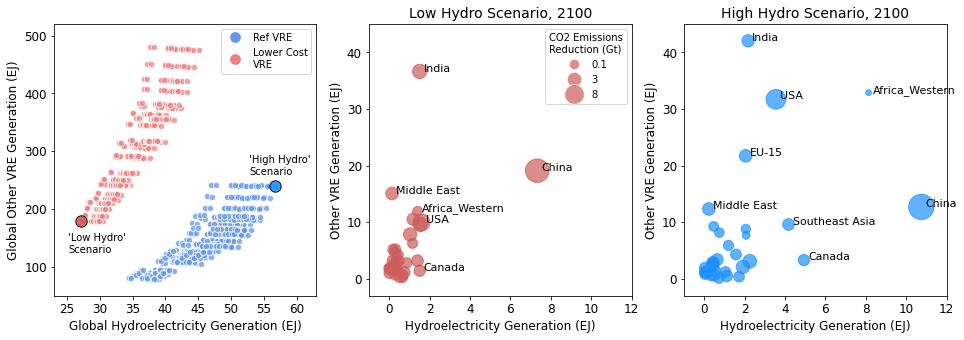

In [56]:
fig, axis = plt.subplots(1, 3, figsize=(16,5), constrained_layout=False)

axis[0].scatter(elec_gen_tech_hydro_vre_merge_glb_net_vre0.total_hydro, elec_gen_tech_hydro_vre_merge_glb_net_vre0.other_vre, 
               c = 'cornflowerblue', alpha = 0.75, s = 40, edgecolors='white')
axis[0].scatter(elec_gen_tech_hydro_vre_merge_glb_net_vre1.total_hydro, elec_gen_tech_hydro_vre_merge_glb_net_vre1.other_vre, 
               c = 'lightcoral', alpha = 0.75, s = 40, edgecolors='white')

axis[0].scatter(net_hi.total_hydro, net_hi.other_vre, c = 'dodgerblue', alpha = 0.9, s = 130, edgecolors='black')
axis[0].scatter(net_lo.total_hydro, net_lo.other_vre, c = 'IndianRed', alpha = 0.9, s = 130, edgecolors='black')
axis[0].annotate("'High Hydro'\nScenario" , (net_hi.total_hydro-4, net_hi.other_vre+20))
axis[0].annotate("'Low Hydro'\nScenario" , (net_lo.total_hydro-2, net_lo.other_vre-55))

axis[1].scatter(elec_gen_tech_hydro_vre_merge_2100_lo.total_hydro, elec_gen_tech_hydro_vre_merge_2100_lo.other_vre, 
            s = (co2_reg_hi_lo_merge.co2_red_lo+3)*35, c = 'IndianRed', alpha = 0.7) 
axis[2].scatter(elec_gen_tech_hydro_vre_merge_2100_hi.total_hydro, elec_gen_tech_hydro_vre_merge_2100_hi.other_vre, 
            s = (co2_reg_hi_lo_merge.co2_red_hi+3)*35, c = 'dodgerblue', alpha = 0.7) 

for i in range(len(reg_trim_lo)): 
    axis[1].annotate(reg_trim_lo[i], 
                    (elec_gen_tech_hydro_vre_merge_2100_lo.total_hydro[i]+0.2, 
                     elec_gen_tech_hydro_vre_merge_2100_lo.other_vre[i]), fontsize = 11)
    
for i in range(len(reg_trim_hi)): 
    axis[2].annotate(reg_trim_hi[i], 
                    (elec_gen_tech_hydro_vre_merge_2100_hi.total_hydro[i]+0.2, 
                     elec_gen_tech_hydro_vre_merge_2100_hi.other_vre[i]), fontsize = 11)
    
axis[0].set_xlabel('Global Hydroelectricity Generation (EJ)', size=12)
axis[0].set_ylabel('Global Other VRE Generation (EJ)', size=12)
axis[0].set_xticks([25,30,35,40,45,50,55,60]); axis[0].set_yticks([100,200,300,400,500])
axis[0].set_xticklabels(['25','30','35','40','45','50','55','60'], fontsize=12)
axis[0].set_yticklabels(['100','200','300','400','500'], fontsize=12)

axis[1].set_xlabel('Hydroelectricity Generation (EJ)', size=12)
axis[1].set_ylabel('Other VRE Generation (EJ)', size=12)
axis[1].set_xticks([0,2,4,6,8,10,12]); axis[1].set_yticks([0,10,20,30,40])
axis[1].set_xticklabels(['0','2','4','6','8','10','12'], fontsize=12)
axis[1].set_yticklabels(['0','10','20','30','40'], fontsize=12)

axis[2].set_xlabel('Hydroelectricity Generation (EJ)', size=12)
axis[2].set_ylabel('Other VRE Generation (EJ)', size=12)
axis[2].set_xticks([0,2,4,6,8,10,12]); axis[2].set_yticks([0,10,20,30,40])
axis[2].set_xticklabels(['0','2','4','6','8','10','12'], fontsize=12)
axis[2].set_yticklabels(['0','10','20','30','40'], fontsize=12)

axis[1].set_title("Low Hydro Scenario, 2100", fontsize = 14)
axis[2].set_title("High Hydro Scenario, 2100", fontsize = 14)


axis[0].set_xlim(23,63); axis[0].set_ylim(50,520)
axis[1].set_xlim(-1,12); axis[1].set_ylim(-3,45)
axis[2].set_xlim(-1,12); axis[2].set_ylim(-3,45)

ref_legend = matplotlib.lines.Line2D([], [], color="white", markerfacecolor="cornflowerblue", 
                                     marker='o', markersize=np.sqrt(4*35))
low_legend = matplotlib.lines.Line2D([], [], color="white", markerfacecolor="lightcoral", 
                                     marker='o', markersize=np.sqrt(4*35))

axis[0].legend((ref_legend, low_legend), ("Ref VRE","Lower Cost\nVRE"), numpoints=1,
           loc = 'upper right', prop = { "size": 10 })


co2_1 = matplotlib.lines.Line2D([], [], color="white", markerfacecolor="IndianRed", 
                                alpha = 0.7, marker='o', markersize=np.sqrt(3.1*35))
co2_2 = matplotlib.lines.Line2D([], [], color="white", markerfacecolor="IndianRed", 
                                alpha = 0.7, marker='o', markersize=np.sqrt(6*35))
co2_3 = matplotlib.lines.Line2D([], [], color="white", markerfacecolor="IndianRed", 
                                alpha = 0.7, marker='o', markersize=np.sqrt(11*35))

axis[1].legend((co2_1, co2_2, co2_3), 
           ("0.1","3","8"), numpoints=1,
           loc = 'upper right', prop = { "size": 10 }, title="CO2 Emissions\nReduction (Gt)")

# Figure 4a-4b: Regional Analysis with PCA

In [71]:
elec_gen_tech_hydro_merge_2100 = elec_gen_tech_hydro_merge[elec_gen_tech_hydro_merge['year']==2100]
elec_gen_tech_hydro_merge_2100_reg = elec_gen_tech_hydro_merge_2100.groupby(['scenario','region'])['value'].sum().reset_index()

elec_gen_tech_hydro_merge_2100_reg_med = elec_gen_tech_hydro_merge_2100_reg.groupby('region')['value'].median().reset_index()
elec_gen_tech_hydro_merge_2100_reg_med.sort_values(by=['value'], ascending=False).region.unique()

array(['China', 'Africa_Western', 'USA', 'Brazil', 'EU-15', 'Canada',
       'India', 'Southeast Asia', 'Africa_Southern', 'Africa_Eastern',
       'Russia', 'Colombia', 'South America_Southern',
       'European Free Trade Association', 'South America_Northern',
       'South Asia', 'Europe_Non_EU', 'Indonesia', 'Australia_NZ',
       'EU-12', 'Japan', 'Pakistan', 'Central Asia', 'Mexico',
       'Africa_Northern', 'Argentina', 'Central America and Caribbean',
       'Middle East', 'Europe_Eastern', 'South Korea', 'Taiwan',
       'South Africa'], dtype=object)

In [72]:
reg_list_median_sorted_true = ['China', 'Africa_Western', 'USA', 'Brazil', 'EU-15', 'Canada',
       'India', 'Southeast Asia', 'Africa_Southern', 'Africa_Eastern',
       'Russia', 'Colombia', 'South America_Southern',
       'European Free Trade Association', 'South America_Northern',
       'South Asia', 'Europe_Non_EU', 'Indonesia', 'Australia_NZ',
       'EU-12', 'Japan', 'Pakistan', 'Central Asia', 'Mexico',
       'Africa_Northern', 'Argentina', 'Central America and Caribbean',
       'Middle East', 'Europe_Eastern', 'South Korea', 'Taiwan',
       'South Africa']

In [73]:
reg_list_median_sorted = ['China', 'Africa_Western', 'USA', 'Brazil', 'EU-15', 'Canada',
       'India', 'Southeast Asia', 'Africa_Southern', 'Africa_Eastern',
       'Russia', 'Colombia', 'SA_Southern',
       'EFTA', 'SA_Northern',
       'South Asia', 'Europe_Non_EU', 'Indonesia', 'Australia_NZ',
       'EU-12', 'Japan', 'Pakistan', 'Central Asia', 'Mexico',
       'Africa_Northern', 'Argentina', 'CA & Carib',
       'Middle East', 'Europe_Eastern', 'South Korea', 'Taiwan',
       'South Africa']
len(reg_list_median_sorted)

32

In [74]:
elec_gen_tech_hydro_merge_2100_glb = elec_gen_tech_hydro_merge_2100_reg.groupby(['scenario'])['value'].sum().reset_index()
elec_gen_tech_hydro_merge_2100_glb = elec_gen_tech_hydro_merge_2100_glb.rename(columns={'value':'gbl_hydro'})

elec_gen_tech_hydro_reg_2100_merge = pd.merge(elec_gen_tech_hydro_merge_2100_reg, elec_gen_tech_hydro_merge_2100_glb, 
                                              how='left', on = ['scenario'])
elec_gen_tech_hydro_reg_2100_merge = elec_gen_tech_hydro_reg_2100_merge.assign(reg_frc = lambda x: x.value/x.gbl_hydro)

In [75]:
elec_gen_tech_2100 = elec_gen_tech[elec_gen_tech['year']==2100]
elec_gen_tech_2100_total = elec_gen_tech_2100.groupby(['scenario','region'])['value'].sum().reset_index()
elec_gen_tech_2100_total = elec_gen_tech_2100_total.rename(columns={'value':'reg_elec'})

elec_gen_tech_2100_total_merge = pd.merge(elec_gen_tech_2100_total, elec_gen_tech_hydro_merge_2100_reg, 
                                          how = 'left', on = ['scenario','region'])
elec_gen_tech_2100_total_merge = elec_gen_tech_2100_total_merge.assign(reg_hydro_share = lambda x: x.value/x.reg_elec)

Text(0, 0.5, '')

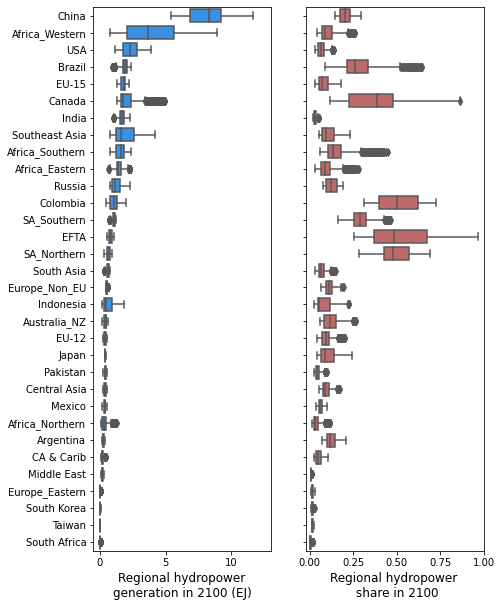

In [76]:
(fig, (ax1,ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(7,10))    

fig = sns.boxplot(x='value', y='region', data=elec_gen_tech_hydro_reg_2100_merge, orient = 'h', 
                  order = reg_list_median_sorted_true, color = 'dodgerblue', ax=ax1)

ax1.set_xlim(-0.5,13)
ax1.set_xlabel('Regional hydropower\ngeneration in 2100 (EJ)', size=12)
ax1.set_ylabel('', size=11)
ax1.set_yticklabels(reg_list_median_sorted)

fig = sns.boxplot(x='reg_hydro_share', y='region', data=elec_gen_tech_2100_total_merge, orient = 'h', 
                  order = reg_list_median_sorted_true, color = 'IndianRed', ax=ax2)

ax2.set(yticklabels=[])
ax2.set_xlim(-0.02,1)
ax2.set_xlabel('Regional hydropower \n share in 2100', size=12)
ax2.set_ylabel('', size=11)


In [77]:
hydro_reg_frc_2100_pivot = pd.pivot_table(elec_gen_tech_hydro_reg_2100_merge,
                                            values = 'reg_frc', index=['scenario'], columns=['region'])
reg_hydro_share_2100_pivot = pd.pivot_table(elec_gen_tech_2100_total_merge,
                                            values = 'reg_hydro_share', index=['scenario'], columns=['region'])
reg_list = ['Africa_Eastern', 'Africa_Northern', 'Africa_Southern',
       'Africa_Western', 'Argentina', 'Australia_NZ', 'Brazil', 'Canada',
       'Central America and Caribbean', 'Central Asia', 'China',
       'Colombia', 'EU-12', 'EU-15', 'Europe_Eastern', 'Europe_Non_EU',
       'European Free Trade Association', 'India', 'Indonesia', 'Japan',
       'Mexico', 'Middle East', 'Pakistan', 'Russia', 'South Africa',
       'South America_Northern', 'South America_Southern', 'South Asia',
       'South Korea', 'Southeast Asia', 'Taiwan', 'USA']

reg_list_trim_1 = [' ', ' ', ' ',
       'Africa_Western', ' ', ' ', 'Brazil', 'Canada',
       ' ', ' ', 'China',
       '', ' ', ' ', ' ', ' ',
       'EFTA', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ',
       '', 'SA_Southern', ' ',
       ' ', ' ', ' ', ' ']
reg_list_trim_2 = [' ', ' ', ' ',
       'Africa_Western', ' ', ' ', 'Brazil', 'Canada',
       ' ', ' ', 'China',
       'Colombia', ' ', ' ', ' ', ' ',
       'EFTA', ' ', ' ', ' ',
       ' ', ' ', ' ', ' ', ' ',
       'SA_Northern', 'SA_Southern', ' ',
       ' ', ' ', ' ', ' ']

In [78]:
hydro_reg_frc_2100_pivot_T = hydro_reg_frc_2100_pivot.transpose()
reg_hydro_share_2100_pivot_T = reg_hydro_share_2100_pivot.transpose()

In [79]:
hydro_reg_frc_x = hydro_reg_frc_2100_pivot_T.loc[:,].values
hydro_reg_frc_x = StandardScaler().fit_transform(hydro_reg_frc_x) # normalizing the features
np.mean(hydro_reg_frc_x),np.std(hydro_reg_frc_x)


(8.018277400070574e-18, 1.0)

In [80]:
reg_share_x = reg_hydro_share_2100_pivot_T.loc[:,].values
reg_share_x = StandardScaler().fit_transform(reg_share_x) # normalizing the features
np.mean(reg_share_x),np.std(reg_share_x)


(-5.268419445559192e-19, 1.0)

In [81]:
pca_hydro_frc_2100 = PCA(n_components=3)
principalComponents_hydro_frc_2100 = pca_hydro_frc_2100.fit_transform(hydro_reg_frc_x)
print('Explained variability per principal component: {}'.format(pca_hydro_frc_2100.explained_variance_ratio_))


Explained variability per principal component: [0.95731733 0.03133956 0.00488956]


In [82]:
pca_reg_share_2100 = PCA(n_components=3)
principalComponents_reg_share_2100 = pca_reg_share_2100.fit_transform(reg_share_x)
print('Explained variability per principal component: {}'.format(pca_reg_share_2100.explained_variance_ratio_))


Explained variability per principal component: [0.92143012 0.05234203 0.01220881]


[Text(0, -30.0, '-20'),
 Text(0, -20.0, '-10'),
 Text(0, -10.0, '0'),
 Text(0, 0.0, '10'),
 Text(0, 10.0, '20'),
 Text(0, 20.0, '30'),
 Text(0, 30.0, '40'),
 Text(0, 40.0, '')]

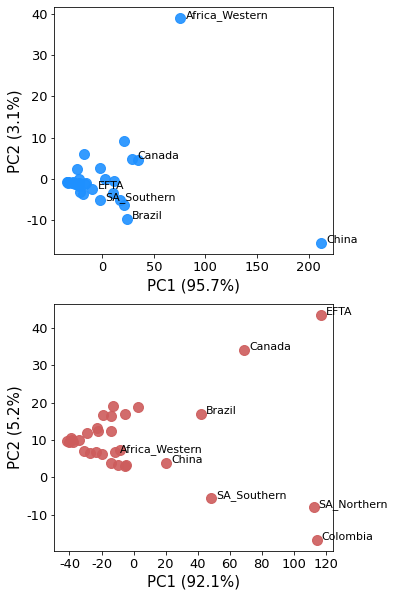

In [83]:
(fig, (ax1,ax2)) = plt.subplots(nrows=2, ncols=1, figsize=(5,10))    

ax1.scatter(principalComponents_hydro_frc_2100[:,0], principalComponents_hydro_frc_2100[:,1], 
            color = 'dodgerblue', alpha = 0.9, s = 100)
ax2.scatter(principalComponents_reg_share_2100[:,0], principalComponents_reg_share_2100[:,1], 
            color = 'IndianRed', alpha = 0.9, s = 100)

for i in range(len(reg_list_trim_1)): 
    ax1.annotate(reg_list_trim_1[i], 
                 (principalComponents_hydro_frc_2100[i,0]+5, principalComponents_hydro_frc_2100[i,1]), 
                 fontsize = 11)
    
for i in range(len(reg_list_trim_2)): 
    ax2.annotate(reg_list_trim_2[i], 
                 (principalComponents_reg_share_2100[i,0]+3, principalComponents_reg_share_2100[i,1]), 
                 fontsize = 11)
    
ax1.set_xlabel('PC1 (95.7%)', size=15); ax1.set_ylabel('PC2 (3.1%)', size=15)
ax2.set_xlabel('PC1 (92.1%)', size=15); ax2.set_ylabel('PC2 (5.2%)', size=15)

ax1.set_xticklabels([-50,0,50,100,150,200], size = 13); ax1.set_yticklabels([-20,-10,0,10,20,30,40], size = 13)
ax2.set_xticklabels([-60,-40,-20,0,20,40,60,80,100,120], size = 13); ax2.set_yticklabels([-20,-10,0,10,20,30,40], size = 13)

# Figure 5: Regression Tree for Regional Hydro Gen & Share

## 5-1: Regression Tree Data Prep & Send out as CSV

In [85]:
fut_cf_hep_2100 = pd.read_csv(fpath + 'Processed_Data/fut_cf_hep_2100.csv', index_col = 0)
fut_cf_hep_2100 = fut_cf_hep_2100.drop(['scenario'],axis=1)

In [86]:
hydro_gen_reg_2100_rt = elec_gen_tech_hydro_reg_2100_merge.drop(['gbl_hydro','reg_frc'], axis=1)
hydro_gen_reg_2100_rt = hydro_gen_reg_2100_rt.rename(columns={'value':'reg_hydro_gen'})
hydro_share_reg_2100_rt = elec_gen_tech_2100_total_merge.drop(['reg_elec','value'], axis=1)

In [87]:
hydro_gen_share_reg_2100_rt = pd.merge(hydro_gen_reg_2100_rt, hydro_share_reg_2100_rt, 
                                       how = 'left', on = ['scenario','region'])

hydro_gen_share_reg_2100_rt['scenario'] = hydro_gen_share_reg_2100_rt.scenario.str.replace('kim_hydrocc_','')

hydro_gen_share_reg_2100_rt_ref = hydro_gen_share_reg_2100_rt[hydro_gen_share_reg_2100_rt.scenario.str.contains('ref_')]
hydro_gen_share_reg_2100_rt_net = hydro_gen_share_reg_2100_rt[hydro_gen_share_reg_2100_rt.scenario.str.contains('net_')]

In [88]:
hydro_gen_share_reg_2100_rt_ref['ccs'] = "ccs0"

hydro_gen_share_reg_2100_rt_ref['tr'] = hydro_gen_share_reg_2100_rt_ref.scenario.str.split('_').str[-1]
hydro_gen_share_reg_2100_rt_ref['bl'] = hydro_gen_share_reg_2100_rt_ref.scenario.str.split('_').str[-2]
hydro_gen_share_reg_2100_rt_ref['rt'] = hydro_gen_share_reg_2100_rt_ref.scenario.str.split('_').str[-3]
hydro_gen_share_reg_2100_rt_ref['rcp'] = hydro_gen_share_reg_2100_rt_ref.scenario.str.split('_').str[-4]
hydro_gen_share_reg_2100_rt_ref['esm'] = hydro_gen_share_reg_2100_rt_ref.scenario.str.split('_').str[-6]
hydro_gen_share_reg_2100_rt_ref['soc'] = hydro_gen_share_reg_2100_rt_ref.scenario.str.split('_').str[-7]
hydro_gen_share_reg_2100_rt_ref['co2'] = hydro_gen_share_reg_2100_rt_ref.scenario.str.split('_').str[-8]

In [89]:
hydro_gen_share_reg_2100_rt_net['ccs'] = hydro_gen_share_reg_2100_rt_net.scenario.str.split('_').str[-1]
hydro_gen_share_reg_2100_rt_net['tr'] = hydro_gen_share_reg_2100_rt_net.scenario.str.split('_').str[-2]
hydro_gen_share_reg_2100_rt_net['bl'] = hydro_gen_share_reg_2100_rt_net.scenario.str.split('_').str[-3]
hydro_gen_share_reg_2100_rt_net['rt'] = hydro_gen_share_reg_2100_rt_net.scenario.str.split('_').str[-4]
hydro_gen_share_reg_2100_rt_net['rcp'] = hydro_gen_share_reg_2100_rt_net.scenario.str.split('_').str[-5]
hydro_gen_share_reg_2100_rt_net['esm'] = hydro_gen_share_reg_2100_rt_net.scenario.str.split('_').str[-7]
hydro_gen_share_reg_2100_rt_net['soc'] = hydro_gen_share_reg_2100_rt_net.scenario.str.split('_').str[-8]
hydro_gen_share_reg_2100_rt_net['co2'] = hydro_gen_share_reg_2100_rt_net.scenario.str.split('_').str[-9]

In [90]:
hydro_gen_share_reg_2100_rt_ref_net = pd.concat([hydro_gen_share_reg_2100_rt_ref,hydro_gen_share_reg_2100_rt_net])
hydro_gen_share_reg_2100_rt_ref_net = hydro_gen_share_reg_2100_rt_ref_net.drop(['scenario'],axis = 1)

In [91]:
hydro_gen_share_reg_2100_rt_ref_net_merge = pd.merge(hydro_gen_share_reg_2100_rt_ref_net, fut_cf_hep_2100, how = 'left', 
                                                     left_on = ['region','esm','rcp'], right_on = ['reg_nm','esm','rcp'])
hydro_gen_share_reg_2100_rt_ref_net_merge = hydro_gen_share_reg_2100_rt_ref_net_merge.drop(['reg_nm','rcp','esm'], axis=1)
hydro_gen_share_reg_2100_rt_ref_net_merge = hydro_gen_share_reg_2100_rt_ref_net_merge.fillna(0)

In [92]:
hydro_gen_share_reg_2100_rt_ref_net_merge = hydro_gen_share_reg_2100_rt_ref_net_merge[['region','co2','ccs','rt',
                                                                                        'soc','bl','tr',
                                                                                        'hep_fut_prd','cf_fut_prd',
                                                                                        'reg_hydro_gen','reg_hydro_share']]

## 5-2: Run Regression Tree in RScript ".R"

## 5-3: Draw Regression Tree Heatmaps

In [94]:
df_table_hydro_gen_2100 =  pd.read_csv(fpath + 'Processed_Data/CART_Results/RT_reg_hydro_gen_2100_Oct29.csv', index_col=[0])
df_table_hydro_share_2100 =  pd.read_csv(fpath + 'Processed_Data/CART_Results/RT_reg_hydro_share_2100_Oct29.csv', index_col=[0])

df_table_hydro_gen_2100  = df_table_hydro_gen_2100.drop(columns=['%IncMSE','metric'])
df_table_hydro_share_2100 = df_table_hydro_share_2100.drop(columns=['%IncMSE','metric'])

In [95]:
df_table_hydro_gen_2100.columns = ['IncNodePurity','varnames','region']
df_table_hydro_share_2100.columns = ['IncNodePurity','varnames','region']

In [96]:
reg_list_median_sorted = ['China', 'Africa_Western', 'USA', 'Brazil', 'EU-15', 'Canada',
                           'India', 'Southeast Asia', 'Africa_Southern', 'Africa_Eastern',
                           'Russia', 'Colombia', 'South America_Southern',
                           'European Free Trade Association', 'South America_Northern',
                           'South Asia', 'Europe_Non_EU', 'Indonesia', 'Australia_NZ',
                           'EU-12', 'Japan', 'Pakistan', 'Central Asia', 'Mexico',
                           'Africa_Northern', 'Argentina', 'Central America and Caribbean',
                           'Middle East', 'Europe_Eastern', 'South Korea', 'Taiwan', 'South Africa']
len(reg_list_median_sorted)

32

In [97]:
#Normalize the variable importances across basins
for rg in df_table_hydro_gen_2100.region.unique()[:]: #loop through the basins
     df_filt = df_table_hydro_gen_2100[df_table_hydro_gen_2100.region==rg] #select basin 
     sum_val_elec = df_filt['IncNodePurity'].sum() #sum up the raw IncNodePurity variable importance values
     df_table_hydro_gen_2100.loc[df_table_hydro_gen_2100['region']==rg,
                                  'norm_IncNodePurity'] = df_table_hydro_gen_2100['IncNodePurity']/sum_val_elec #normalize
        
#pivot the dataframe for heatmap plotting
df_pivot_hydro_gen = pd.pivot_table(data=df_table_hydro_gen_2100,values='norm_IncNodePurity',index=['region'],columns=['varnames'])
df_pivot_hydro_gen = df_pivot_hydro_gen.filter(['co2','ccs','rt','soc','bl','tr','hep_fut_prd','cf_fut_prd']) #reorder columns (x-axis) of heatmap


In [98]:
#Normalize the variable importances across basins
for rg in df_table_hydro_share_2100.region.unique()[:]: #loop through the basins
     df_filt = df_table_hydro_share_2100[df_table_hydro_share_2100.region==rg] #select region
     sum_val_hydro = df_filt['IncNodePurity'].sum() #sum up the raw IncNodePurity variable importance values
     df_table_hydro_share_2100.loc[df_table_hydro_share_2100['region']==rg,
                                  'norm_IncNodePurity'] = df_table_hydro_share_2100['IncNodePurity']/sum_val_hydro #normalize
        
#pivot the dataframe for heatmap plotting
df_table_hydro_share_2100 = df_table_hydro_share_2100.fillna(value=0)
df_pivot_hydro_share = pd.pivot_table(data=df_table_hydro_share_2100,values='norm_IncNodePurity',index=['region'],columns=['varnames'])
df_pivot_hydro_share = df_pivot_hydro_share.filter(['co2','ccs','rt','soc','bl','tr','hep_fut_prd','cf_fut_prd']) #reorder columns (x-axis) of heatmap


Text(0.5, 358.6200000000002, '')

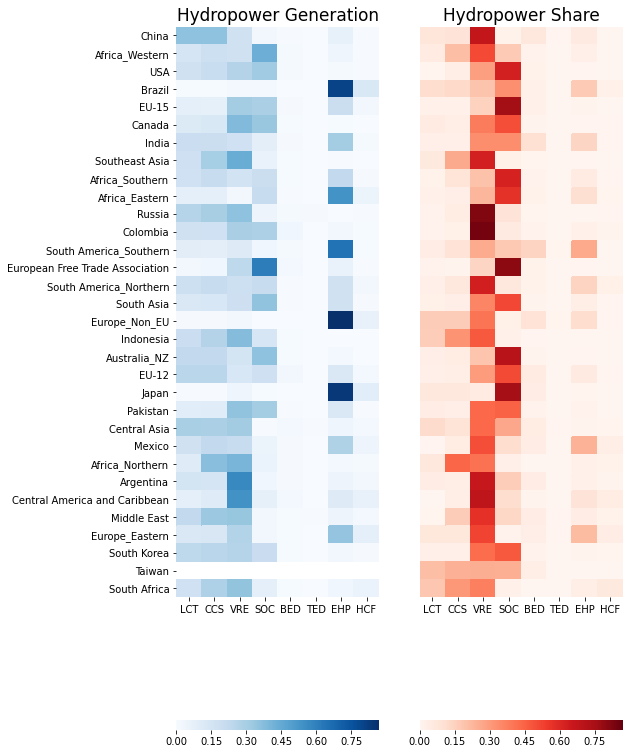

In [99]:
 #PLOT - to get version without annotated text set annot = False and to get version without basins labeled set yticklabels = False
(fig, (ax1,ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(8,15))

sns.heatmap(pd.DataFrame(df_pivot_hydro_gen).reindex(reg_list_median_sorted_true),cmap='Blues', ax=ax1,
                cbar_kws={'label':"",'orientation':'horizontal'}, vmin = 0, vmax= 0.87, 
                xticklabels=['LCT','CCS','VRE','SOC','BED','TED','EHP','HCF'], yticklabels=True,
                annot=False,fmt='.2f')
    
ax1.set_title("Hydropower Generation", fontsize = 17)
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_yticklabels(reg_list_median_sorted)

sns.heatmap(pd.DataFrame(df_pivot_hydro_share).reindex(reg_list_median_sorted_true),cmap='Reds', ax=ax2,
                cbar_kws={'label':"",'orientation':'horizontal'}, vmin = 0, vmax= 0.87, 
                xticklabels=['LCT','CCS','VRE','SOC','BED','TED','EHP','HCF'], yticklabels=False,
                annot=False,fmt='.2f')
    
ax2.set_title("Hydropower Share", fontsize = 17)
ax2.set_ylabel('')
ax2.set_xlabel('')


# Annotated Version of Figure 5 (In SI as Figure S4)

Text(0.5, 358.6200000000002, '')

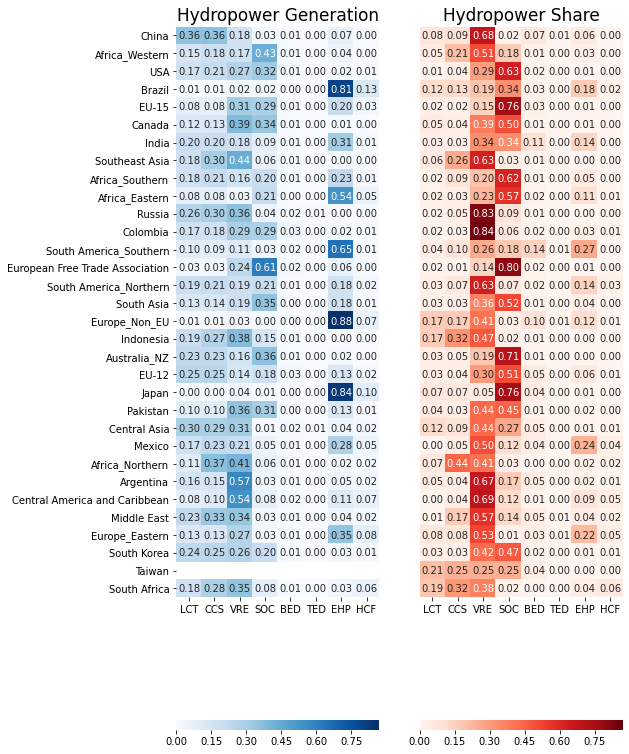

In [100]:
 #PLOT - to get version without annotated text set annot = False and to get version without basins labeled set yticklabels = False
(fig, (ax1,ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(8,15))

sns.heatmap(pd.DataFrame(df_pivot_hydro_gen).reindex(reg_list_median_sorted_true),cmap='Blues', ax=ax1,
                cbar_kws={'label':"",'orientation':'horizontal'}, vmin = 0, vmax= 0.87, 
                xticklabels=['LCT','CCS','VRE','SOC','BED','TED','EHP','HCF'], yticklabels=True,
                annot=True,fmt='.2f')
    
ax1.set_title("Hydropower Generation", fontsize = 17)
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_yticklabels(reg_list_median_sorted)

sns.heatmap(pd.DataFrame(df_pivot_hydro_share).reindex(reg_list_median_sorted_true),cmap='Reds', ax=ax2,
                cbar_kws={'label':"",'orientation':'horizontal'}, vmin = 0, vmax= 0.87, 
                xticklabels=['LCT','CCS','VRE','SOC','BED','TED','EHP','HCF'], yticklabels=False,
                annot=True,fmt='.2f')
    
ax2.set_title("Hydropower Share", fontsize = 17)
ax2.set_ylabel('')
ax2.set_xlabel('')
